## Series raiz unitarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from arch.unitroot import ADF, DFGLS, PhillipsPerron

import warnings
warnings.simplefilter("ignore")

Primero vamos a generar una serie estacionaria que servira de ejemplo

In [2]:
np.random.seed(12345)
ar_p = np.array([1])
ma_p = np.array([0])

# Incluyo una constante. Para el caso del AR debo colocarlo en negativo
ar = np.r_[1, -ar_p]
ma = np.r_[1, ma_p]

serie = arma_generate_sample(ar, ma, nsample=2000)
serie = pd.Series(serie)

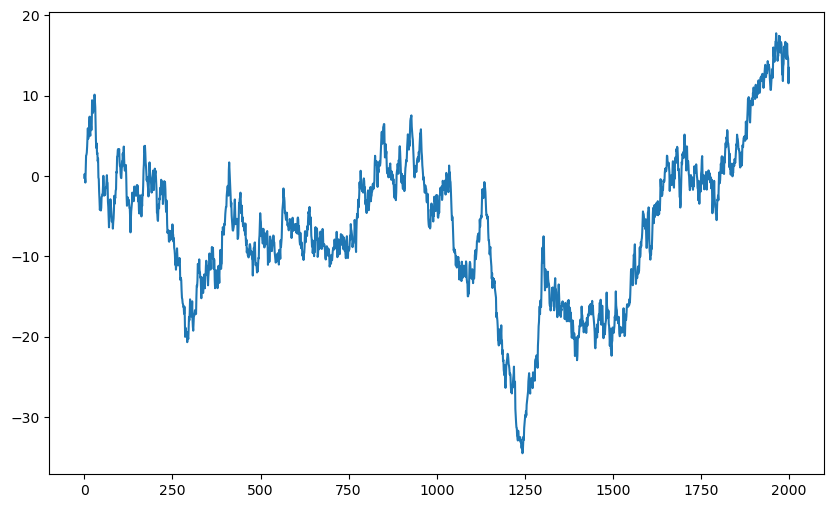

In [3]:
fig = plt.figure(figsize=(10,6))
fig = plt.plot(serie)

plt.savefig("./Graficas/ur_generated.pdf")
plt.show()

Cuando una serie es raiz unitara, aun se puede estimar por un modelo ARMA, pero provocara lo siguiente:
* La estimacion sera sesgada
* Los residuos contaran con autocorrelacion serial

Una de las maneras de saber si una serie tiene raiz unitaria es mediante la revision de la ACF. Las series con raiz unitaria cuentan con una funcion que decae muy suavemente y cuenta con niveles significativos por muchos periodos

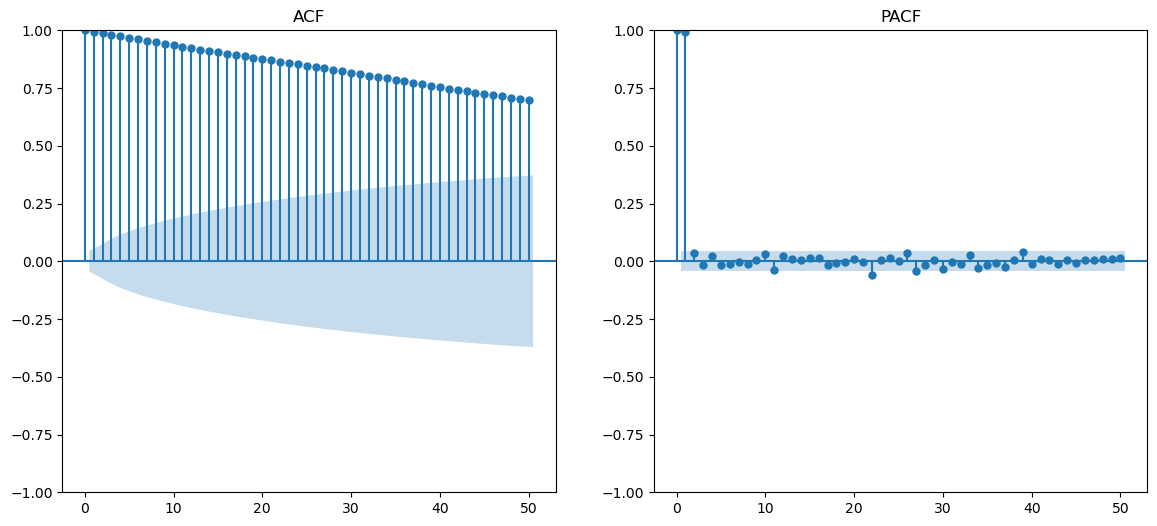

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

plot_acf(serie, ax=ax[0], lags=50, title="ACF", alpha=0.05)
plot_pacf(serie, ax=ax[1], lags=50, title="PACF", alpha=0.05)

plt.savefig("./Graficas/ur_acf_pacf.pdf")
plt.show()

No obstante, la forma mas comun de saber si una serie cuenta tiene raiz unitaria es mediante tests:
1. Dickey-Fuller ($DF$)
2. Dickey-Fuller aumentado ($ADF$)
3. Phillips-Perron ($PP$)
4. Estadisticos M
5. Elliot-Rotenberg-Stock ($DF_{GLS}$)

Con la libreria `arch` se puede estimar el $ADF$, $DF_{GLS}$, $PP$

In [5]:
adf = ADF(serie)
df_gls = DFGLS(serie)
pp = PhillipsPerron(serie)

El resultado de los test es el siguiente

In [6]:
print(adf.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.962
P-value                         0.303
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [7]:
print(df_gls.summary())

      Dickey-Fuller GLS Results      
Test Statistic                 -1.812
P-value                         0.069
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -2.58 (1%), -1.95 (5%), -1.63 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [8]:
print(pp.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.771
P-value                         0.395
Lags                               26
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


En dos de los tres test se encuentra la presencia de raiz unitaria. Por lo general, esta se puede solucionar con primeras diferencias

In [9]:
fd = serie - serie.shift(1)
fd = fd[1:]

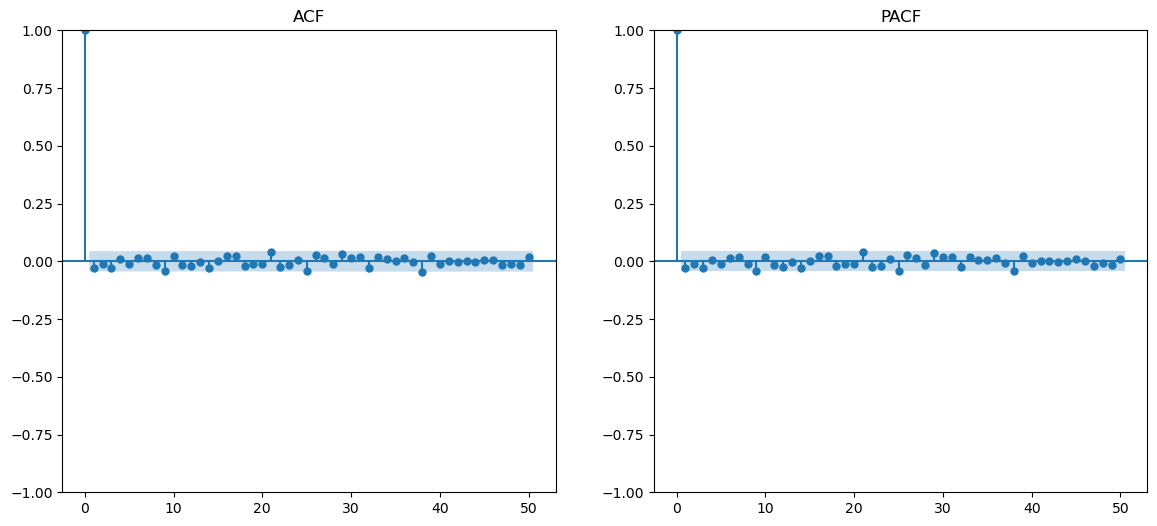

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

plot_acf(fd, ax=ax[0], lags=50, title="ACF", alpha=0.05)
plot_pacf(fd, ax=ax[1], lags=50, title="PACF", alpha=0.05)

plt.savefig("./Graficas/ur_fd_acf_pacf.pdf")
plt.show()

In [11]:
adf = ADF(fd)
df_gls = DFGLS(fd)
pp = PhillipsPerron(fd)

In [12]:
print(adf.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                -45.953
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [13]:
print(df_gls.summary())

      Dickey-Fuller GLS Results      
Test Statistic                -38.221
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -2.58 (1%), -1.95 (5%), -1.63 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [14]:
print(pp.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -46.224
P-value                         0.000
Lags                               26
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Tanto de manera grafica como con los test, ya no existe el problema de raiz unitaria

### Aplicado con data peruana
Realizaré el análisis con la serie del consumo privado

In [15]:
dta = pd.read_excel("./Bases de datos/PeruData.xlsx", sheet_name="Trimestral", skiprows=1)
dta = dta[['Trimestres', 'Producto bruto interno por tipo de gasto (millones S/ 2007) - Demanda Interna - Consumo Privado']]
dta.rename({'Producto bruto interno por tipo de gasto (millones S/ 2007) - Demanda Interna - Consumo Privado': 'Consumo'}, axis=1, inplace=True)
dta = dta.loc[0:159, :]

# Seting index
dta.index = pd.period_range("1980Q3", "2020Q2", freq="Q")

dta = np.log(dta[["Consumo"]])
dta

,Consumo
1980Q3,10.095712
1980Q4,10.098896
1981Q1,10.221229
1981Q2,10.260693
1981Q3,10.248834
...,...
2019Q2,11.353857
2019Q3,11.353392
2019Q4,11.419034
2020Q1,11.400895


In [16]:
dta.index=dta.index.to_timestamp()

# Suavizamiento
dta_sa = seasonal_decompose(dta, model="multiplicative").trend

dta_sa = dta_sa.dropna()
dta = dta[(dta.index >= "1981-01-01") & (dta.index <= "2019-10-01")]

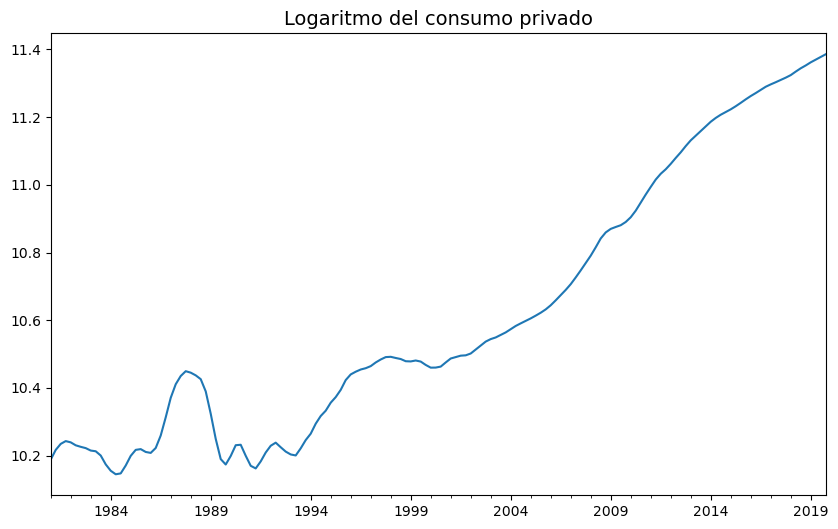

In [17]:
plt.figure(figsize=(10, 6))

dta_sa.plot()

plt.title("Logaritmo del consumo privado", fontsize=14)
plt.show()

Se puede realizar una revision de si existe raiz unitaria

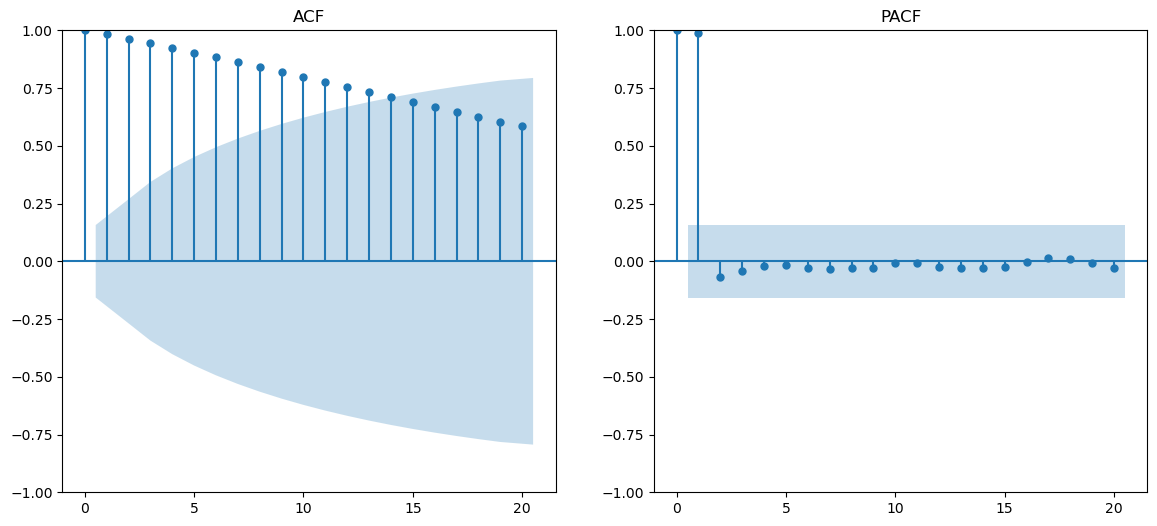

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

plot_acf(dta_sa, ax=ax[0], lags=20, title="ACF", alpha=0.05)
plot_pacf(dta_sa, ax=ax[1], lags=20, title="PACF", alpha=0.05)

plt.savefig("./Graficas/ur_consumo_acf_pacf.pdf")
plt.show()

In [19]:
adf = ADF(dta_sa)
print(adf.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                  0.944
P-value                         0.994
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


`No se puede` rechazar la raiz unitaria en la serie del consumo privado. Se podria solucionar con primeras diferencias o con variaciones anuales

In [20]:
consumo = (dta_sa - dta_sa.shift(1))*100
consumo = consumo[1:]
consumo

1981-04-01    2.869752
1981-07-01    1.776748
1981-10-01    0.825228
1982-01-01   -0.370167
1982-04-01   -0.870944
                ...   
2018-10-01    0.836260
2019-01-01    0.923804
2019-04-01    0.798274
2019-07-01    0.780265
2019-10-01    0.800857
Freq: QS-OCT, Name: trend, Length: 155, dtype: float64

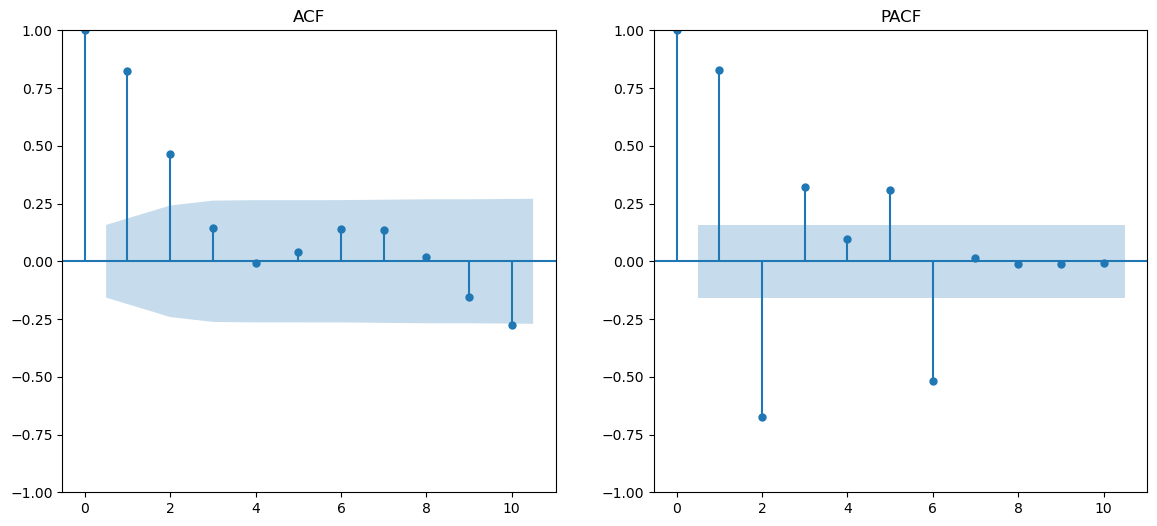

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

plot_acf(consumo, ax=ax[0], lags=10, title="ACF", alpha=0.05)
plot_pacf(consumo, ax=ax[1], lags=10, title="PACF", alpha=0.05)

plt.show()

In [22]:
adf = ADF(consumo)
print(adf.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.777
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Luego, ya se soluciono el problema de raiz unitaria

In [23]:
criterias = arma_order_select_ic(consumo, max_ar=4, max_ma=2, ic=["aic", "bic"])

print(f"El mejor modelo seleccionado por AIC es {criterias.aic_min_order} y por BIC es {criterias.bic_min_order}")

El mejor modelo seleccionado por AIC es (3, 1) y por BIC es (2, 1)


Siguiendo el criterio del BIC, el modelo seleccionado deberia ser un ARMA(2,1)

In [24]:
model = tsa.arima.ARIMA(consumo, order=(2,0,1))
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                  155
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -143.250
Date:                Mon, 07 Nov 2022   AIC                            296.501
Time:                        01:50:47   BIC                            311.718
Sample:                    04-01-1981   HQIC                           302.682
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8118      0.307      2.641      0.008       0.209       1.414
ar.L1          0.9679      0.060     16.132      0.000       0.850       1.085
ar.L2         -0.3120      0.061     -5.121      0.0

In [25]:
model_f = model.get_forecast(steps=10)

# Proyeciones
model_mean = model_f.predicted_mean
model_ci = model_f.conf_int()

# Generando los DataFrames
fc_series = pd.Series(model_mean)
lower_series = pd.Series(model_ci["lower trend"])
upper_series = pd.Series(model_ci["upper trend"])

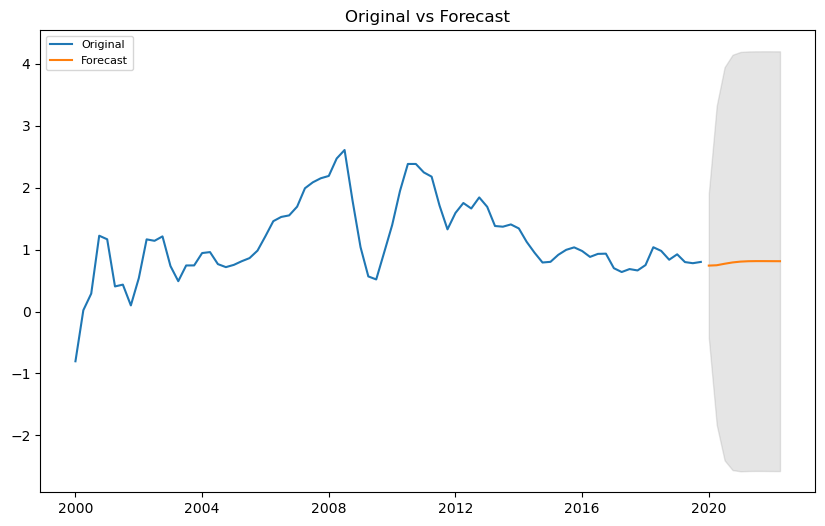

In [26]:
# Plot
plt.figure(figsize=(10,6))

plt.plot(consumo[(consumo.index >= "2000-01-01")], label="Original")
plt.plot(fc_series, label="Forecast")

# Fill
plt.fill_between(lower_series.index, lower_series, upper_series, color="grey", alpha=0.2)

plt.title("Original vs Forecast")
plt.legend(loc="upper left", fontsize=8)

plt.savefig("./Graficas/forecast_consumo_out_sample.pdf")
plt.show()